# FEM Modelling for Single-Phase STEDIN Transformer

### Voltage-fed Analysis - Non-Linear BH Curve

The nonlinear magnetic characteristic with hysteresis neglected can be approximated as given in [1].
\begin{equation}
    \frac{1}{\mu} = k_1 e^{k_2B^2} + k_3
\end{equation}
where, $k_1$, $k_2$ and $k_3$ are constants equal to 3.8, 2.17, and 396.2, respectively.

[1] J. Brauer, “Simple equations for the magnetization and reluctivity curves of steel,” IEEE Transactions on Magnetics, vol. 11, no. 1, pp. 81–81, 1975.

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_VoltageFed_Tri_1e.jl");
using .FEM_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Frequency.jl");
using .Post_Process_Frequency
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK

## BH Curve

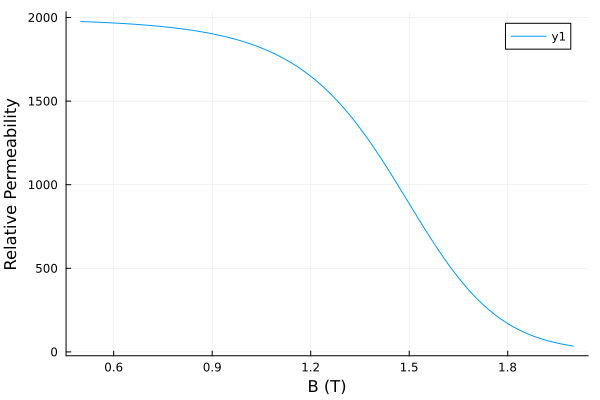

In [2]:
# Plot of mu vs B
mu0 = 4e-7 * pi;
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    mu0 = 4e-7 * pi;
    v = k1 * exp(k2*B^2) + k3;
    if (1 ./ v)/mu0 < 10
        v = 1 / 10 / mu0;  
    end
    return (1 ./ v)
end

B = collect(range(0.5, 2.0, 100))
plot(B,mu_func.(B)/mu0)
xlabel!("B (T)")
ylabel!("Relative Permeability")

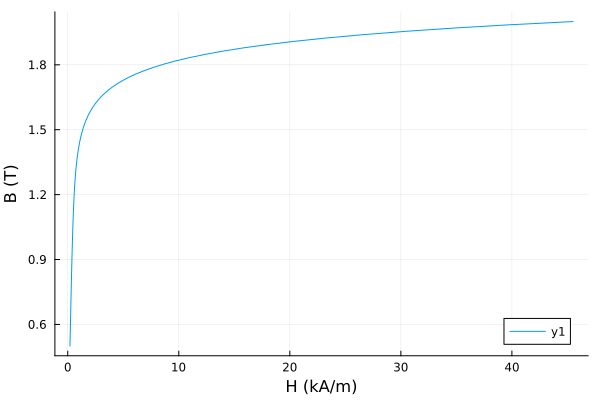

In [3]:
plot(B./mu_func.(B)/1000,B)
xlabel!("H (kA/m)")
ylabel!("B (T)")

## Julia code

In [4]:
gmsh.initialize()

## Read mesh from file
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==5))  -Tp*(1*(group_id==6))   Ts*(1*(group_id==11))  -Ts*(1*(group_id==12))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp; Vp; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = [90.655; 90.655; 1.2999e-3; 1.2999e-3];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = 1e-4.*[1; 1; 1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

mur_pts = findall(x->x==2, mesh_data.e_group)
L = LinearIndices(mesh_data.e_group)
mur_pts = L[mur_pts]
    
## Threshold value for the error
threshold = 1e-4 .* ones(length(mur_pts))

u, Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

for loop = 1:500
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance);

    # Post-process for magnetic field and current density
    Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u[1:mesh_data.nnodes], reluctivityperelement);

    ## Check the error with the threshold values
    if abs.((1 ./ mu_func.(abs.(B[mur_pts]))) - reluctivityperelement[mur_pts]) <= threshold
        break;
    end

    ## Assign new value of mur
    reluctivityperelement[mur_pts] = 1 ./ mu_func.(abs.(B[mur_pts]));
end

# Contour plot of the magnetic flux density
plot_surface_tri_1e(norm.(B), "single_phase_stedin_transformer_B_plot_nonlinear", gmsh)
# Contour plot of the magnetic field strength
plot_surface_tri_1e(norm.(H), "single_phase_stedin_transformer_H_plot_nonlinear", gmsh)
# Contour plot of the magnetic energy
plot_surface_tri_1e(norm.(mag_energy), "single_phase_stedin_transformer_mag_energy_plot_nonlinear", gmsh)
# Contour plot of the relative permeability
plot_surface_tri_1e((1 ./reluctivityperelement ./mu0), "single_phase_stedin_transformer_permeability_plot_nonlinear", gmsh)

# Save as VTK file for Paraview visualization
save_vtk(mesh_data, imag(u[1:mesh_data.nnodes]), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, "single_phase_stedin_transformer_nonlinear")

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'


### STEDIN Transformer : Magnetic field density
<img src="../img/single_phase_stedin_transformer_B_plot_nonlinear.png">

### STEDIN Transformer : Magnetic field strength
<img src="../img/single_phase_stedin_transformer_H_plot_nonlinear.png">

### STEDIN Transformer : Magnetic energy
<img src="../img/single_phase_stedin_transformer_mag_energy_plot_nonlinear.png">

### STEDIN Transformer : Relative permeability
<img src="../img/single_phase_stedin_transformer_permeability_plot_nonlinear.png">

In [5]:
display(maximum(norm.(B)))

3.138509663209402

In [6]:
display(norm.(B[7051]))

0.011757260198599725